In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torchvision.datasets import STL10 as dataset
import time
from tqdm import tqdm
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import glob
from torch.utils.data import Dataset, DataLoader

device

device(type='cuda')

## Data

In [2]:
data_path = '/content/drive/MyDrive/data'


In [3]:
!ls -ltriah /content/drive/MyDrive/data

total 2.7G
70 -rw------- 1 root root 211M Apr 20  2024 processed_data.pickle.gz
71 drwx------ 2 root root 4.0K Apr 27  2024 semantic_data
72 drwx------ 2 root root 4.0K Apr 27  2024 history_1
73 drwx------ 2 root root 4.0K Apr 27  2024 history
74 drwx------ 2 root root 4.0K Apr 27  2024 model
75 -rw------- 1 root root 2.5G Jan 18 16:24 stl10_binary.tar.gz
76 drwx------ 2 root root 4.0K Jan 18 16:24 stl10_binary
77 drwx------ 2 root root 4.0K Jan 18 16:34 models


### Transformers 🤖

In [29]:
class DualTransformDataset(Dataset):
    def __init__(self, dataset, transform, transform_alpha):
        """
        A custom dataset that applies two different transforms to each image.

        Args:
            dataset (Dataset): The base dataset to use (e.g., STL10, CIFAR-10).
            transform (callable): The first transformation to apply.
            transform_alpha (callable): The second transformation to apply.
        """
        self.dataset = dataset
        self.transform = transform
        self.transform_alpha = transform_alpha

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]  # Get the original image and label
        image1 = self.transform(image) if self.transform else image
        image2 = self.transform_alpha(image) if self.transform_alpha else image
        return image1, image2, label

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

transform_alpha = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),  # Increase Gaussian noise (was 0.01)
    transforms.GaussianBlur(kernel_size=5, sigma=(2.0, 5.0)),  # Apply Gaussian blur
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

### Data loaders

In [5]:
# Download and load the training dataset
train_dataset = datasets.STL10(root=data_path, split='train', download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = datasets.STL10(root=data_path, split='test', download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:


# Load the CIFAR-10 dataset with the transformations
train_dataset_alpha = datasets.STL10(root=data_path, split='train', download=False, transform=transform_alpha)
train_loader_alpha = DataLoader(train_dataset_alpha, batch_size=64, shuffle=False)


# Download and load the testing dataset
test_dataset_alpha = datasets.STL10(root=data_path, split='test', download=False, transform=transform_alpha)
test_loader_alpha = DataLoader(test_dataset_alpha, batch_size=64, shuffle=False)


In [38]:
train_nont_dataset = datasets.STL10(root=data_path, split='train', download=False, transform=None)
train_dual_dataset = DualTransformDataset(train_nont_dataset, transform, transform_alpha)
train_dual_loader = DataLoader(train_dual_dataset, batch_size=64, shuffle=True, num_workers=4)

test_nont_dataset = datasets.STL10(root=data_path, split='test', download=False, transform=None)
test_dual_dataset = DualTransformDataset(test_nont_dataset, transform, transform_alpha)
test_dual_loader = DataLoader(test_dual_dataset, batch_size=64, shuffle=True, num_workers=4)



### Show images

In [7]:
# Display a few sample images from the training dataset
def show_images(data_loader):
    # Get a batch of images
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Unnormalize and plot
    images = images / 2 + 0.5  # Unnormalize
    grid = torchvision.utils.make_grid(images[:8])  # Take first 8 images
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions for plotting
    plt.axis('off')
    plt.show()

# Show some images

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert CHW to HWC for plotting
    plt.axis('off')
    plt.show()


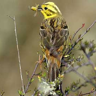

In [35]:
next(iter(train_nont_dataset))[0]

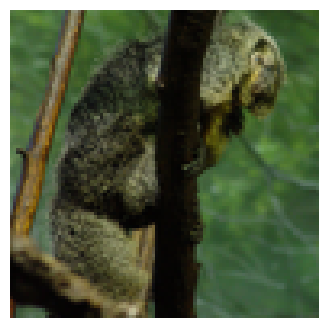

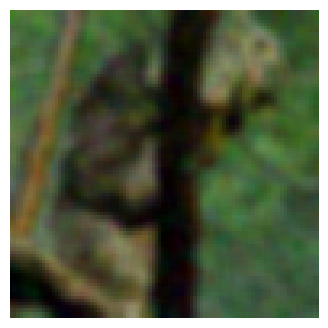

In [44]:
# images, _ = next(iter(train_loader))
# images_alpha, _ = next(iter(train_loader_alpha))
images,images_alpha, _ = next(iter(train_dual_loader))
i = 11
imshow(images[i])
imshow(images_alpha[i])


## Train

In [10]:
def get_new_model():
  model = models.resnet18(pretrained=True)

  # Modify the fully connected layer to match STL10 classes
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, 10)  # STL10 has 10 classes

  # Move the model to the appropriate device (GPU if available)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  return {'model': model, 'criterion': criterion, 'optimizer': optimizer}

In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Initialize tqdm progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update tqdm bar with current loss
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f}s")

    print("Training complete")

In [12]:
model_dict = get_new_model()
model = model_dict['model']
criterion = model_dict['criterion']
optimizer = model_dict['optimizer']

model_alpha_dict = get_new_model()
model_alpha = model_alpha_dict['model']
criterion_alpha = model_alpha_dict['criterion']
optimizer_alpha = model_alpha_dict['optimizer']

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [13]:
train_model(model_alpha, train_loader_alpha, criterion_alpha, optimizer_alpha, num_epochs=10)
with open(f"{data_path}/models/model_alpha_dict_{round(time.time())}.pkl", "wb") as f:
    pickle.dump(model_alpha_dict, f)

Epoch 1/10: 100%|██████████| 79/79 [00:09<00:00,  8.03it/s, loss=1.43]


Epoch 1/10, Loss: 1.1233, Time: 9.85s


Epoch 2/10: 100%|██████████| 79/79 [00:08<00:00,  9.26it/s, loss=0.671]


Epoch 2/10, Loss: 0.6350, Time: 8.54s


Epoch 3/10: 100%|██████████| 79/79 [00:08<00:00,  9.10it/s, loss=0.111]


Epoch 3/10, Loss: 0.4537, Time: 8.68s


Epoch 4/10: 100%|██████████| 79/79 [00:08<00:00,  9.13it/s, loss=0.0734]


Epoch 4/10, Loss: 0.3709, Time: 8.66s


Epoch 5/10: 100%|██████████| 79/79 [00:08<00:00,  9.27it/s, loss=0.0134]


Epoch 5/10, Loss: 0.2729, Time: 8.52s


Epoch 6/10: 100%|██████████| 79/79 [00:08<00:00,  9.22it/s, loss=0.0255]


Epoch 6/10, Loss: 0.1599, Time: 8.57s


Epoch 7/10: 100%|██████████| 79/79 [00:08<00:00,  9.15it/s, loss=0.00612]


Epoch 7/10, Loss: 0.1696, Time: 8.64s


Epoch 8/10: 100%|██████████| 79/79 [00:08<00:00,  9.16it/s, loss=0.00356]


Epoch 8/10, Loss: 0.1290, Time: 8.63s


Epoch 9/10: 100%|██████████| 79/79 [00:08<00:00,  9.38it/s, loss=0.00214]


Epoch 9/10, Loss: 0.1344, Time: 8.43s


Epoch 10/10: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s, loss=0.0309]


Epoch 10/10, Loss: 0.0942, Time: 8.68s
Training complete


In [14]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

with open(f"{data_path}/models/model_alpha_{round(time.time())}.pkl", "wb") as f:
    pickle.dump(model_alpha_dict, f)


Epoch 1/10: 100%|██████████| 79/79 [00:03<00:00, 21.77it/s, loss=0.774]


Epoch 1/10, Loss: 0.9006, Time: 3.63s


Epoch 2/10: 100%|██████████| 79/79 [00:03<00:00, 21.35it/s, loss=2.28]


Epoch 2/10, Loss: 0.4499, Time: 3.71s


Epoch 3/10: 100%|██████████| 79/79 [00:03<00:00, 21.72it/s, loss=0.975]


Epoch 3/10, Loss: 0.3516, Time: 3.64s


Epoch 4/10: 100%|██████████| 79/79 [00:03<00:00, 21.04it/s, loss=0.0616]


Epoch 4/10, Loss: 0.2350, Time: 3.76s


Epoch 5/10: 100%|██████████| 79/79 [00:03<00:00, 21.71it/s, loss=0.00481]


Epoch 5/10, Loss: 0.1337, Time: 3.64s


Epoch 6/10: 100%|██████████| 79/79 [00:03<00:00, 21.60it/s, loss=0.00142]


Epoch 6/10, Loss: 0.1075, Time: 3.66s


Epoch 7/10: 100%|██████████| 79/79 [00:03<00:00, 21.78it/s, loss=0.00496]


Epoch 7/10, Loss: 0.0893, Time: 3.63s


Epoch 8/10: 100%|██████████| 79/79 [00:03<00:00, 21.92it/s, loss=0.241]


Epoch 8/10, Loss: 0.0892, Time: 3.61s


Epoch 9/10: 100%|██████████| 79/79 [00:03<00:00, 21.44it/s, loss=0.000587]


Epoch 9/10, Loss: 0.1143, Time: 3.69s


Epoch 10/10: 100%|██████████| 79/79 [00:03<00:00, 21.71it/s, loss=0.000796]


Epoch 10/10, Loss: 0.0614, Time: 3.64s
Training complete


## Eval

### Reload models

In [ ]:
# Find the latest alpha model
list_of_files = glob.glob(f'{data_path}/models/model_alpha_dict_*.pkl')
latest_alpha_model_file = max(list_of_files, key=os.path.getctime)

# Find the latest normal model (assuming it's saved similarly but without 'alpha' in filename)
list_of_files = glob.glob(f'{data_path}/models/model_alpha_*.pkl')
latest_normal_model_file = max(list_of_files, key=os.path.getctime)

# Load the models
try:
    with open(latest_alpha_model_file, "rb") as f:
        latest_alpha_model = pickle.load(f)
    print(f"Loaded latest alpha model from: {latest_alpha_model_file}")

    with open(latest_normal_model_file, "rb") as f:
        latest_normal_model = pickle.load(f)
    print(f"Loaded latest normal model from: {latest_normal_model_file}")


except FileNotFoundError:
    print(f"Error: Could not find model files in {data_path}/models/")
except Exception as e:
    print(f"An error occurred: {e}")

# Example usage (assuming you want to access the model itself):
# Make sure to handle potential errors if the pickled files don't contain 'model' keys
if 'model' in latest_alpha_model and 'model' in latest_normal_model:
    model_alpha = latest_alpha_model['model']
    model = latest_normal_model['model']

else:
    print("Error: 'model' key not found in one or both loaded model dictionaries.")



### Calculate Losses

In [21]:
def calculate_losses(data_loader, data_loader_alpha, model, model_alpha, criterion):
    model.eval()  # Set both models to evaluation mode
    model_alpha.eval()

    losses_model = []
    losses_model_alpha = []

    # Calculate losses for data_loader with model
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses_model.append(loss.item())

    # Calculate losses for data_loader_alpha with model_alpha
    for inputs, labels in data_loader_alpha:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model_alpha(inputs)
            loss = criterion(outputs, labels)
            losses_model_alpha.append(loss.item())

    return losses_model, losses_model_alpha

In [22]:
losses_model, losses_model_alpha = calculate_losses(test_loader, test_loader_alpha, model, model_alpha, nn.CrossEntropyLoss())

In [23]:
def calculate_loss_deltas(data_loader, data_loader_alpha, model, model_alpha, criterion):
    model.eval()  # Set both models to evaluation mode
    model_alpha.eval()

    loss_deltas = []

    # Ensure the loaders have the same number of images
    for (inputs1, labels1), (inputs2, labels2) in zip(data_loader, data_loader_alpha):
        # Move inputs and labels to the device
        inputs1, labels1 = inputs1.to(device), labels1.to(device)
        inputs2, labels2 = inputs2.to(device), labels2.to(device)

        with torch.no_grad():
            # Get predictions from both models
            outputs1 = model(inputs1)
            outputs2 = model_alpha(inputs2)

            # Compute per-sample losses
            loss1 = torch.nn.functional.cross_entropy(outputs1, labels1, reduction='none')
            loss2 = torch.nn.functional.cross_entropy(outputs2, labels2, reduction='none')

            # Take the magnitude (absolute value) of the losses
            loss1 = torch.abs(loss1)
            loss2 = torch.abs(loss2)

            # Compute delta between losses
            batch_delta = (loss1 - loss2).cpu().tolist()
            loss_deltas.extend(batch_delta)

    return loss_deltas

In [24]:
loss_deltas = calculate_loss_deltas(test_loader, test_loader_alpha, model, model_alpha, nn.CrossEntropyLoss())

In [25]:
np.mean(loss_deltas), np.mean(losses_model), np.mean(losses_model_alpha),np.mean(losses_model) - np.mean(losses_model_alpha)

(-0.12638101630575452,
 1.048774955034256,
 1.1777689542770386,
 -0.12899399924278265)